# SETTING UP

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
from time_series.ts_tools import *
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller as adf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ES
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import periodogram
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pylab import rcParams


# Setting global parameters for plotting

plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titleweight'] = 'bold'


# Supressing all warnings
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Dataset path

path = 'C:/Users/domingosdeeularia/Documents/notyourbusiness/CodingAndAnalytics/Python/Projects/RetailSalesForecast/ers_dataset.xlsx'

In [3]:
# Reading the dataset xls file as a pandas dataframe

retail = pd.read_excel(path)

# EXPLORATORY DATA ANALYSIS 

In [4]:
# Main info of the dataset

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               188 non-null    datetime64[ns]
 1   Water_UnitSales    188 non-null    int64         
 2   Alcohol_UnitSales  188 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.5 KB


In [5]:
# First five records

retail.head()

,Date,Water_UnitSales,Alcohol_UnitSales
0,2019-10-06,166396556,150101757
1,2019-10-13,157116476,147027893
2,2019-10-20,150442968,145748467
3,2019-10-27,149196153,145996632
4,2019-11-03,144728816,146590953


In [6]:
# Passing the date column to be the index and presenting the first five rows

retail.set_index(retail.columns[0], inplace = True)
retail.head()

,Water_UnitSales,Alcohol_UnitSales
Date,,
2019-10-06,166396556,150101757
2019-10-13,157116476,147027893
2019-10-20,150442968,145748467
2019-10-27,149196153,145996632
2019-11-03,144728816,146590953


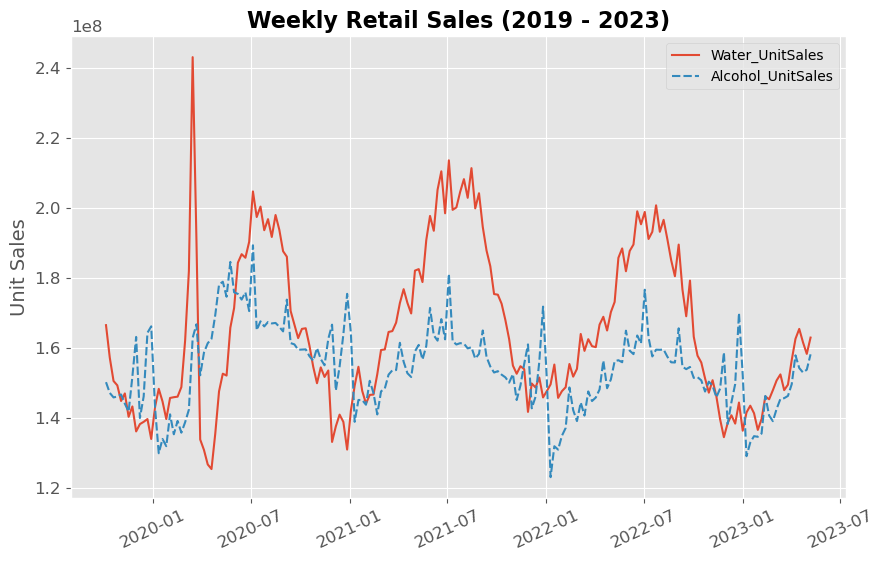

In [7]:
# Comparing water and alchohol sales

sns.lineplot(data = retail, legend = True)
plt.ylabel('Unit Sales')
plt.xlabel('')
plt.xticks(rotation = 25)
plt.title(f'Weekly Retail Sales ({retail.index.min().year} - {retail.index.max().year})')
plt.show()

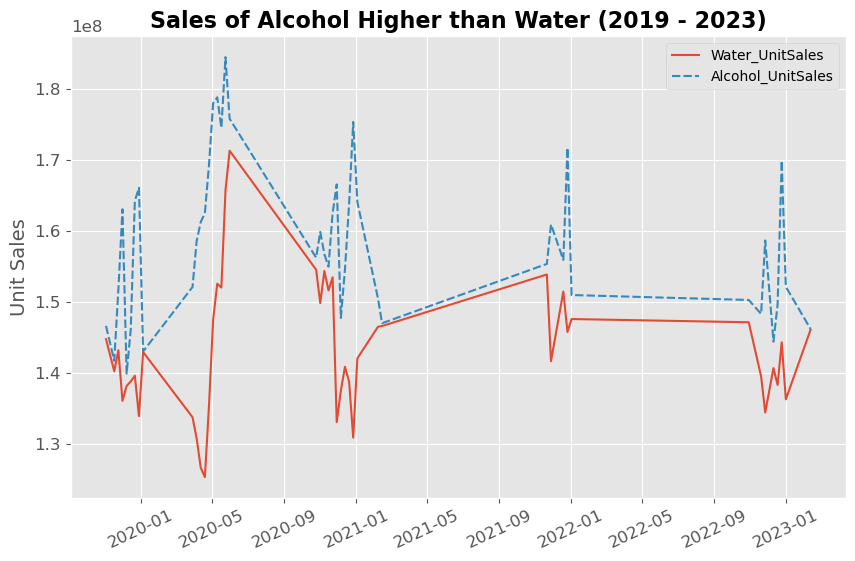

In [8]:
# Cases when alchol sales were hogher than water's

alc_higher_than_water = retail[retail['Alcohol_UnitSales'] > retail['Water_UnitSales']]

# Plot
sns.lineplot(data = alc_higher_than_water, legend = True)
plt.ylabel('Unit Sales')
plt.xlabel('')
plt.xticks(rotation = 25)
plt.title(f'Sales of Alcohol Higher than Water ({alc_higher_than_water.index.min().year} - {alc_higher_than_water.index.max().year})')
plt.show()

### Classic Decomposition

In [9]:
# Dataset for alchohol unit sales

df_alc = retail.iloc[:, -1:]

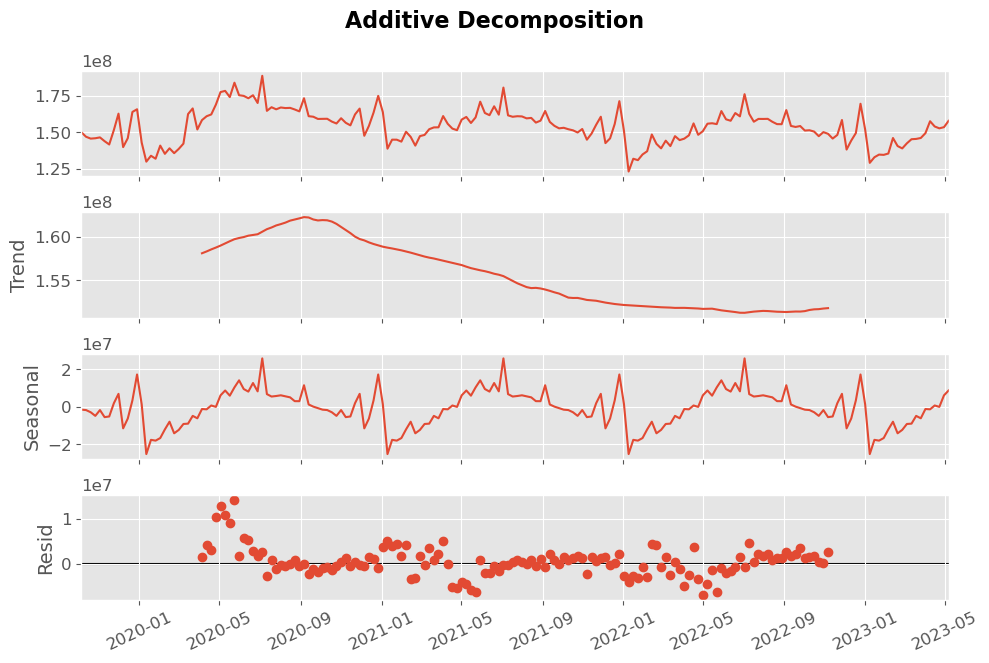

In [10]:
add_dec = seasonal_decompose(df_alc, model = 'additive', period = 52)
add_dec.plot().suptitle('Additive Decomposition', y = 1.05, fontsize = 16, fontweight = 'bold')
plt.xticks(rotation = 25)
plt.show()

### Alternative Decomposition

#### Trend Analysis

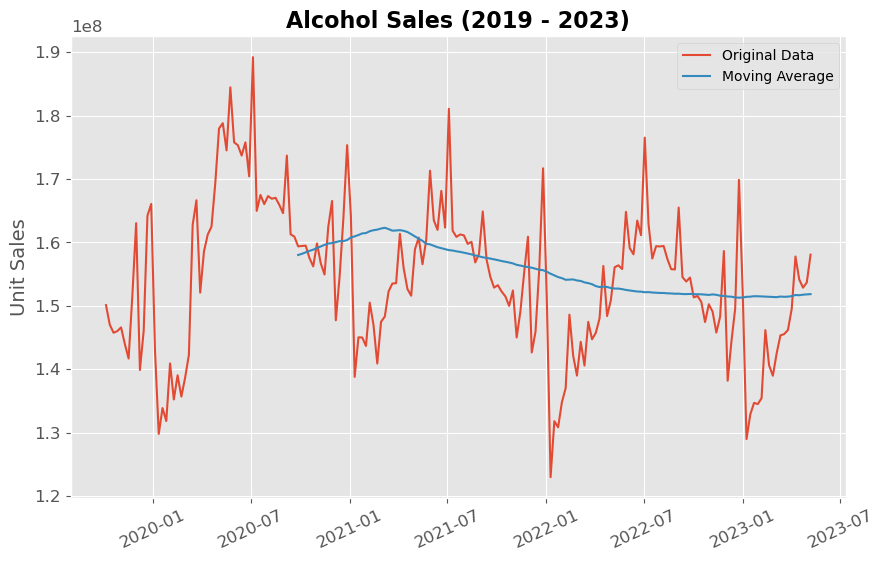

In [11]:
# Trend analysis using the moving average method

plt.plot(df_alc, label = 'Original Data')
plt.plot(df_alc.rolling(52).mean(), label = 'Moving Average')
plt.ylabel('Unit Sales')
plt.xticks(rotation = 25)
plt.legend()
plt.title(f'Alcohol Sales ({df_alc.index.min().year} - {df_alc.index.max().year})')
plt.show()

## Seasonality Detection

#### Periodogram

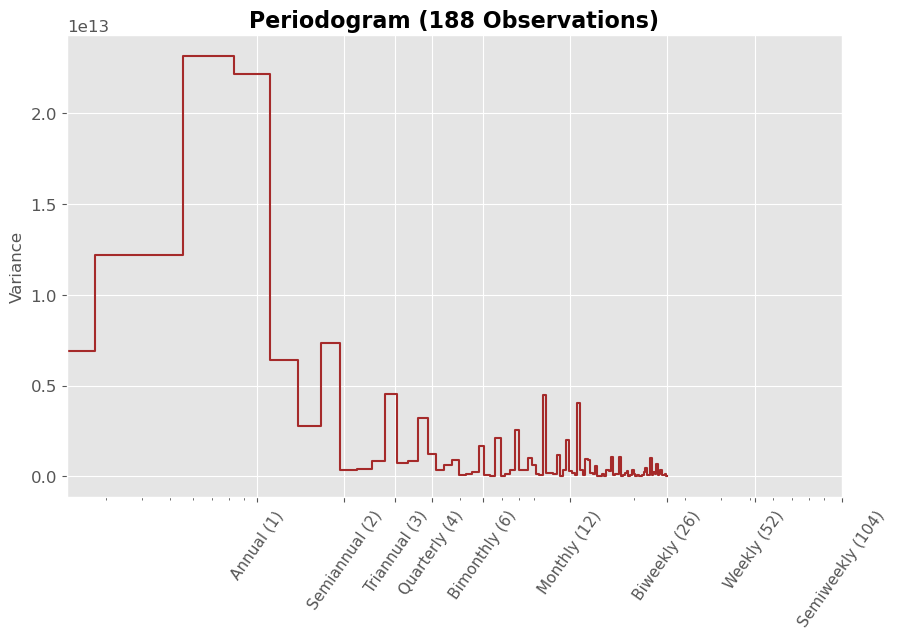

In [12]:
# Presenting the periodogram

show_periodogram(df_alc, fs = 52)

#### Seasonal Plots

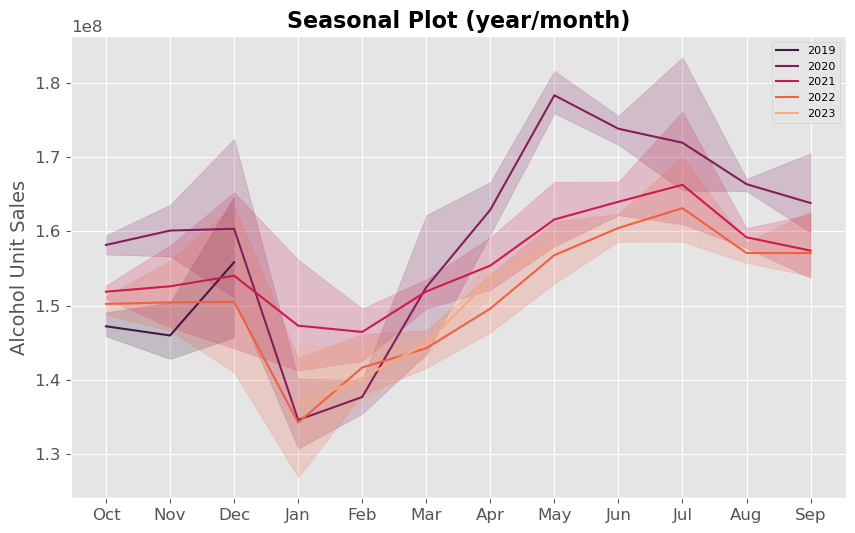

In [13]:
# Months vs. year seasonal analysis (annual period)

show_seasonal(df_alc, 'year', 'month', x_label = 'hide', y_label = 'Alcohol Unit Sales')

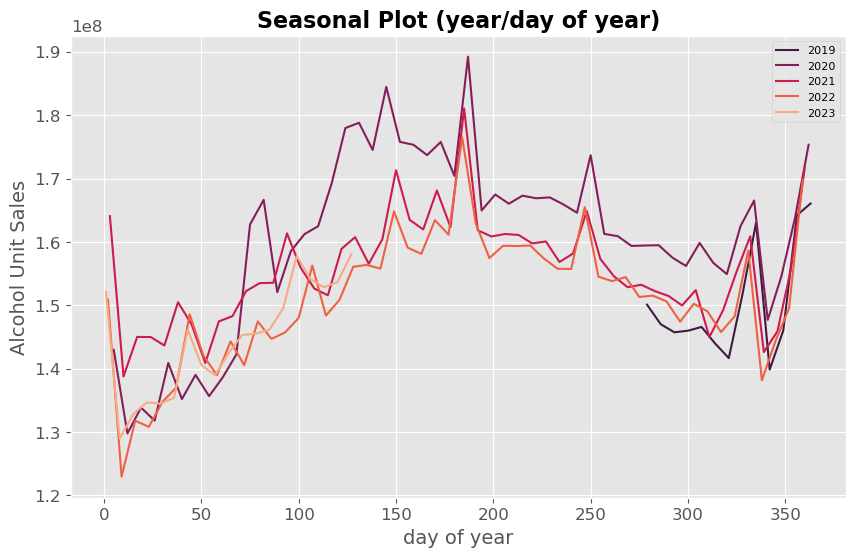

In [14]:
# Year vs. day of year seasonal plot (annual period)

show_seasonal(df_alc, 'year', 'day of year', y_label = 'Alcohol Unit Sales')

## Serial Dependency

### Lag Plots

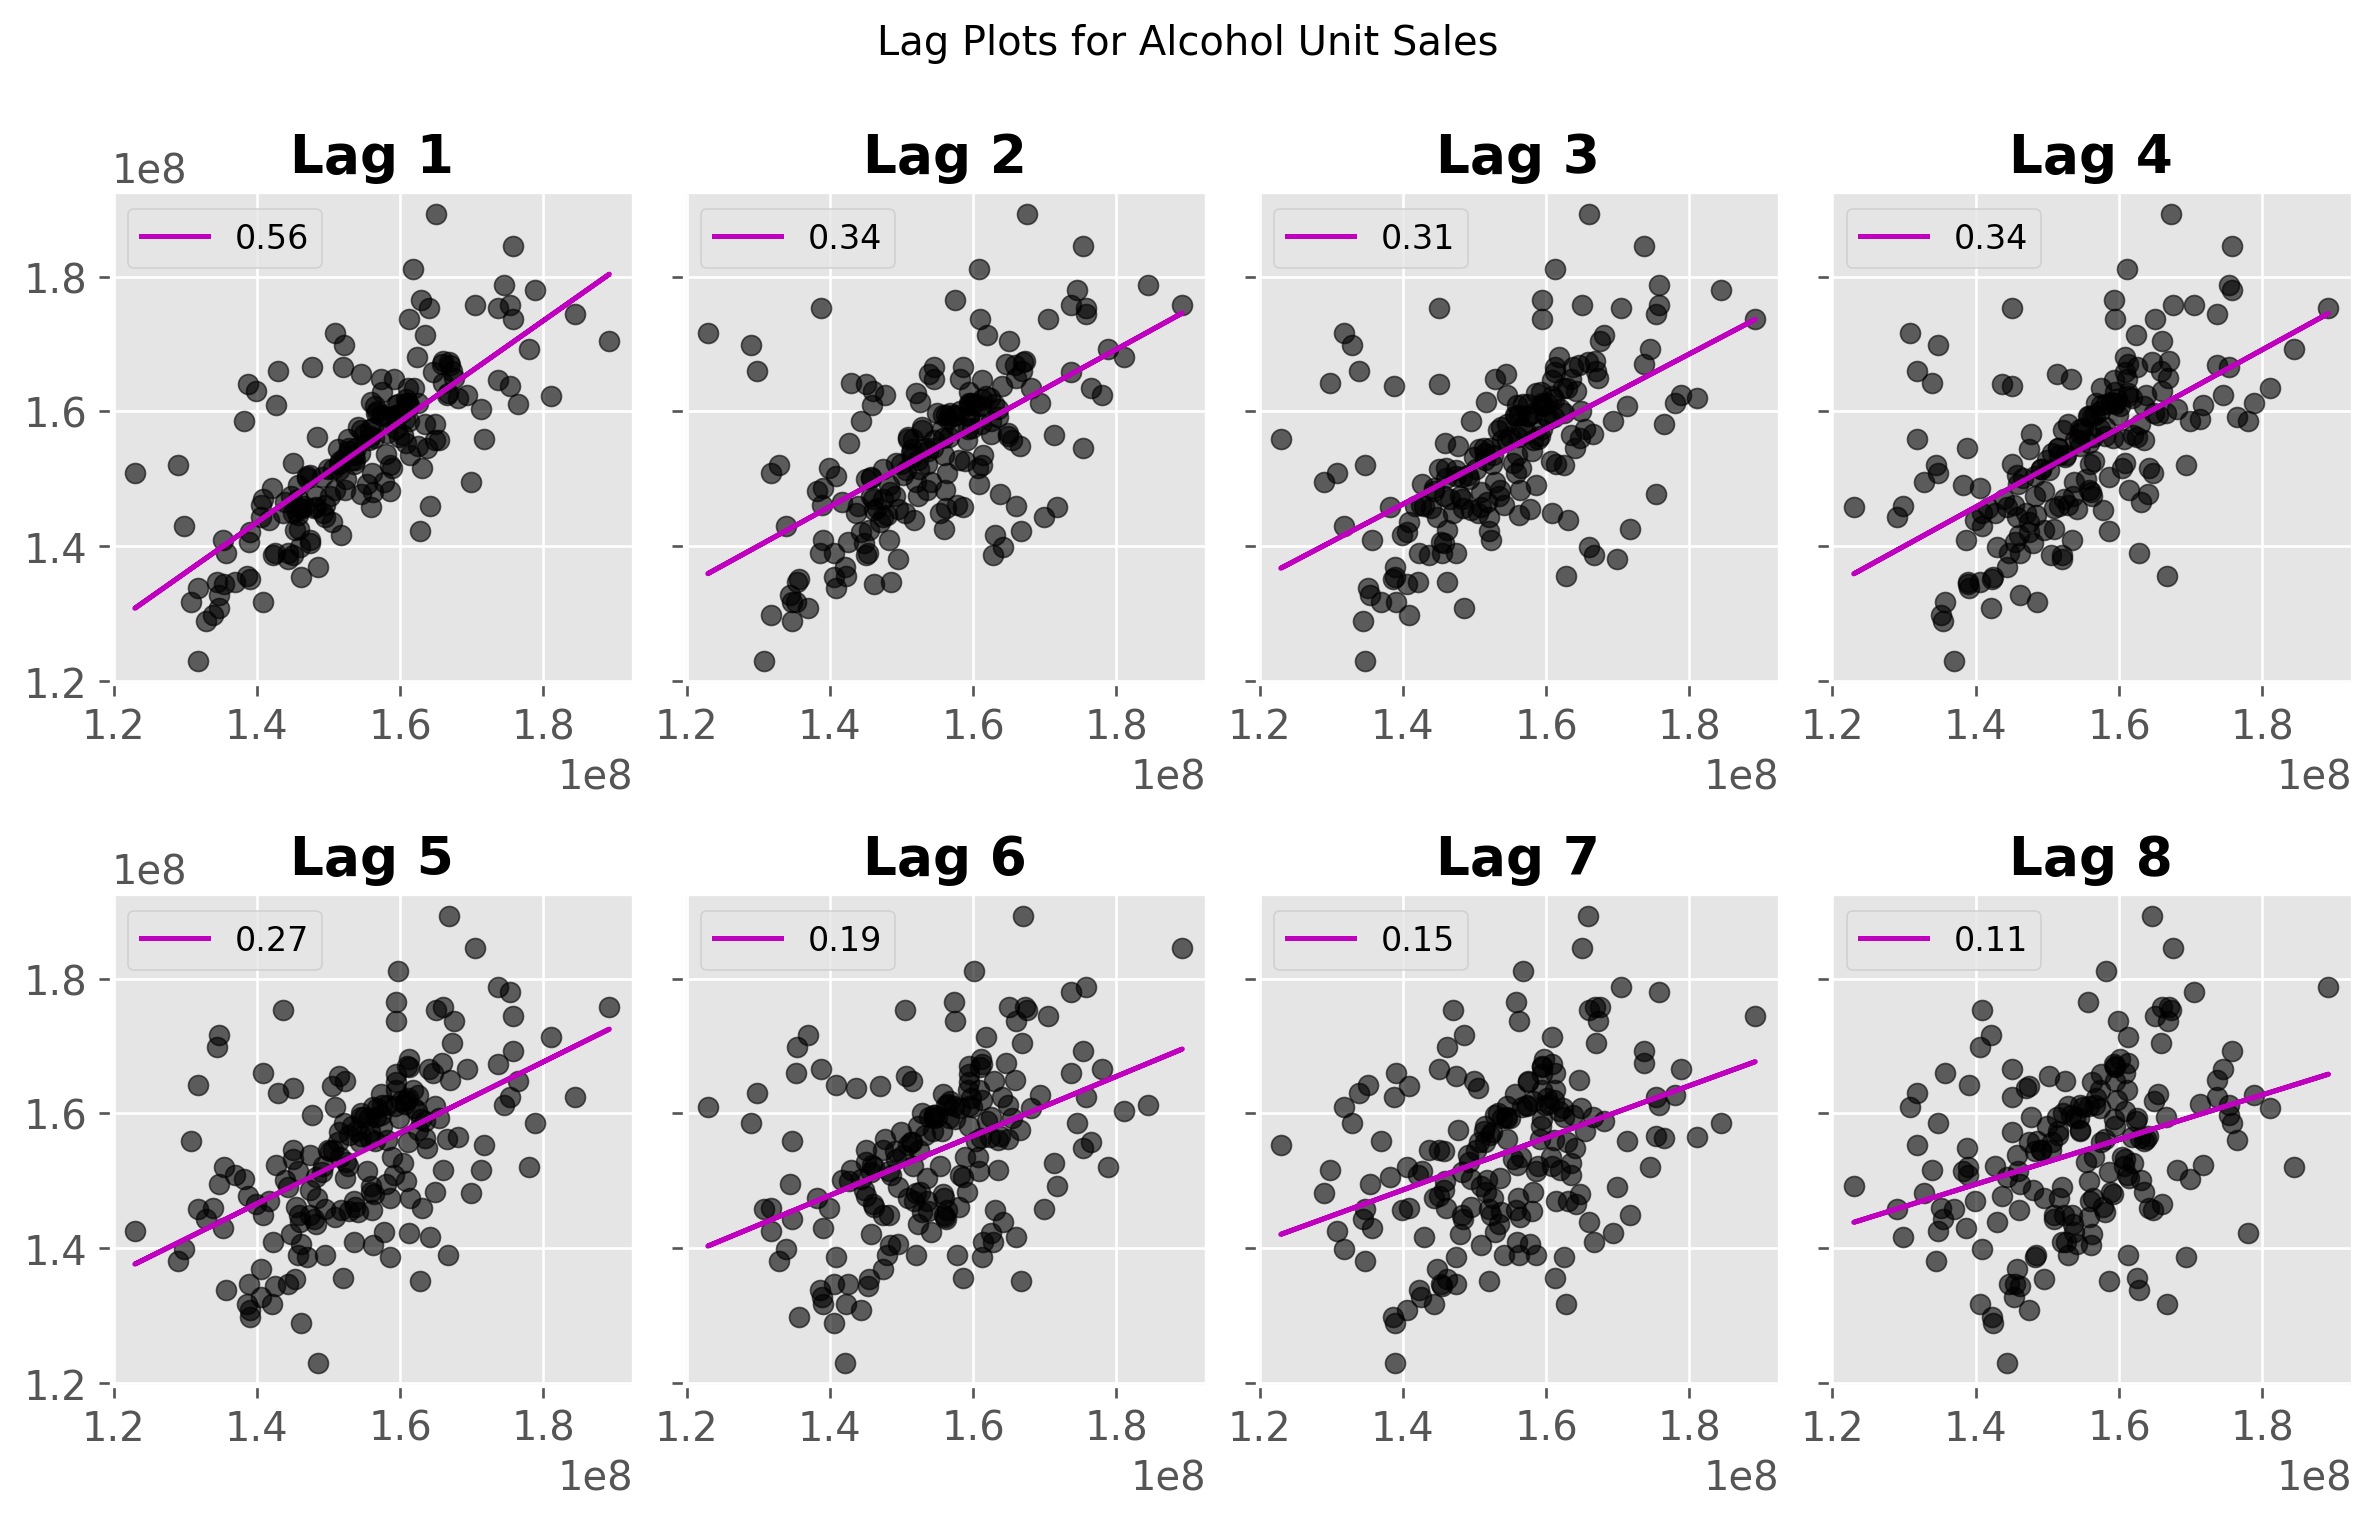

In [15]:
show_lags(df_alc, 8, 'Lag Plots for Alcohol Unit Sales')

# FORECAST

## SARIMA

In [16]:
# ADF test to check stationarity

adf_test(df_alc)

This series is not stationary!

Results of Dickey-Fuller Test


,Scores
Test Statistic,-2.704595
p-value,0.073247
Lags Used,3.000000
Observations,184.000000
Critical Value (1%),-3.466398
Critical Value (5%),-2.877380
Critical Value (10%),-2.575214


- Differencing to remove trend

In [17]:
# First order differencing to make the series stationary

df_alc_diff = df_alc.diff()

In [18]:
# Dropping missing values

df_alc_diff.dropna(inplace = True)

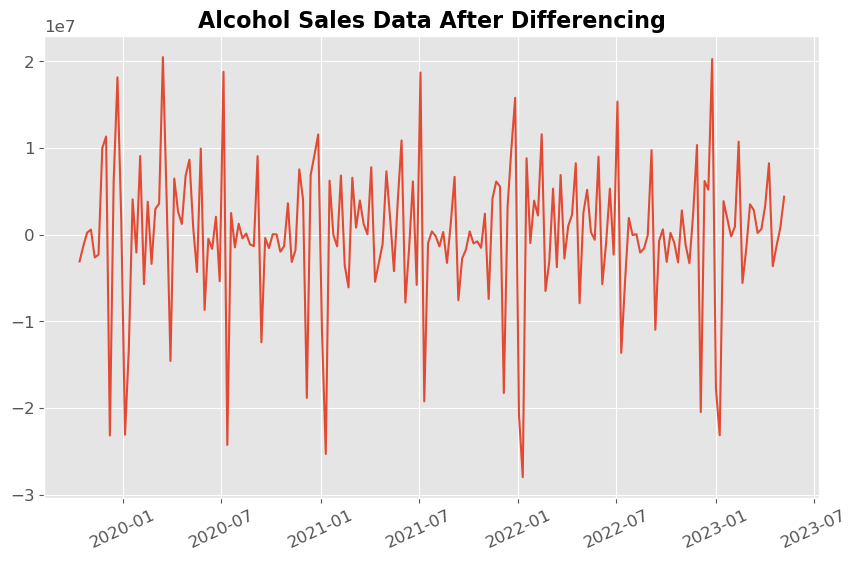

In [19]:
# Plotting the Differenced data

sns.lineplot(data = df_alc_diff, legend = False)
plt.title(f'Alcohol Sales Data After Differencing')
plt.xlabel('')
plt.xticks(rotation = 25)
plt.show()

In [20]:
# ADF test on the differenced series

adf_test(df_alc_diff)

This series is stationary!

Results of Dickey-Fuller Test


,Scores
Test Statistic,-1.260276e+01
p-value,1.721811e-23
Lags Used,2.000000e+00
Observations,1.840000e+02
Critical Value (1%),-3.466398e+00
Critical Value (5%),-2.877380e+00
Critical Value (10%),-2.575214e+00


- Logarithmic Transformation and differencing to stabilize the variance and remove the trend

In [21]:
# Logarithmic Transformation and differencing to stabilize the variance and remove the trend

df_alc_log = np.log(df_alc)

In [22]:
# Differencing and removal of any missing values

df_alc_log_diff = df_alc_log.diff().dropna()

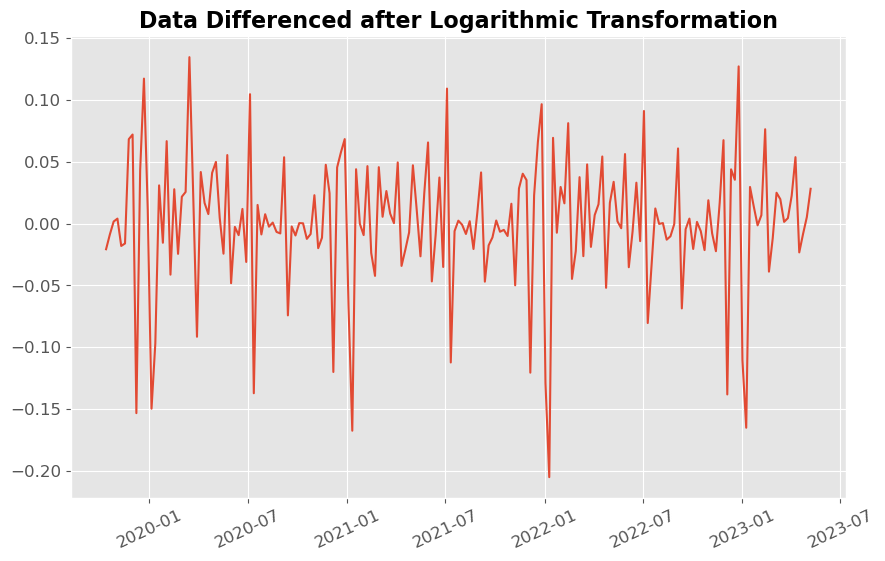

In [23]:
# Plotting the differenced data after log transformation

sns.lineplot(data = df_alc_log_diff, legend = False)
plt.title(f'Data Differenced after Logarithmic Transformation')
plt.xlabel('')
plt.xticks(rotation = 25)
plt.show()

In [24]:
# Performing the ADF test again

adf_test(df_alc_log_diff)

This series is stationary!

Results of Dickey-Fuller Test


,Scores
Test Statistic,-1.250978e+01
p-value,2.690310e-23
Lags Used,2.000000e+00
Observations,1.840000e+02
Critical Value (1%),-3.466398e+00
Critical Value (5%),-2.877380e+00
Critical Value (10%),-2.575214e+00


In [25]:
# Splitting the data

train_data, test_data = split_data(df_alc) # Original scale
train_data_diff, test_data_diff = split_data(df_alc_log_diff) # Data Differenced in log scale

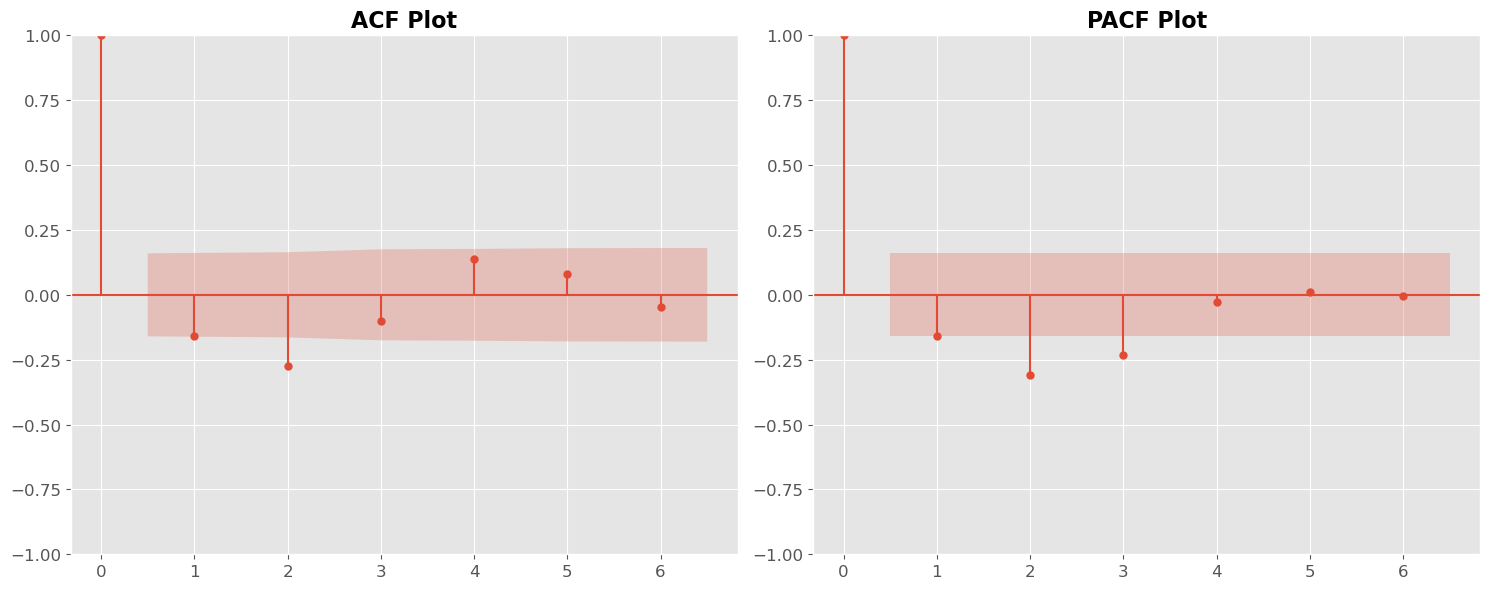

In [26]:
# Displaying the correlogram

show_correlogram(train_data_diff)

In [27]:
# Selecting automatically the order of the ARIMA model

auto_select = auto_arima(train_data_diff, seasonal = True, m = 52, stepwise = True)

In [28]:
# Fitting the model with SARIMA

sarima_model = ARIMA(train_data_diff, order = auto_select.order, seasonal_order = auto_select.seasonal_order)
sarima_model_fit = sarima_model.fit()

In [29]:
# Forecast for the next 23 weeks

steps_diff = len(test_data_diff) + 23
sarima_results = sarima_model_fit.get_forecast(steps = steps_diff)
sarima_forecast_log_diff = sarima_results.predicted_mean

In [30]:
# Reversing the differenced operation for the forecast results: cumulative sum

sarima_forecast_cumsum = sarima_forecast_log_diff.cumsum()


# Reversing the differenced operation for the forecast results in confidence intervals: cumulative sum

sarima_conf_int_cumsum = sarima_results.conf_int().cumsum()
lower_bound_sarima_cumsum = sarima_conf_int_cumsum.iloc[:,0]
upper_bound_sarima_cumsum = sarima_conf_int_cumsum.iloc[:,1]

In [31]:
# setting the base value

base_value = df_alc_log.squeeze().iloc[len(train_data)]
series_base_value = pd.Series(base_value, index = pd.date_range(start = test_data_diff.index[0],
                                                                    periods = steps_diff, freq = 'W'))

In [32]:
# Reversing the forecast value: summing with the base value

sarima_forecast_log = series_base_value.add(sarima_forecast_cumsum, fill_value = 0)


# Reversing the forecast value in confidence intervalos: summing with the base value

lower_bound_sarima_log = series_base_value.add(lower_bound_sarima_cumsum, fill_value = 0)
upper_bound_sarima_log = series_base_value.add(upper_bound_sarima_cumsum, fill_value = 0)

In [33]:
# Reversing the forecast values to the original scale: exponential transformation

sarima_forecast = np.exp(sarima_forecast_log)


# Reversing the forecast values in confidence intervals: exponential transformation

lower_bound_sarima = np.exp(lower_bound_sarima_log)
upper_bound_sarima = np.exp(upper_bound_sarima_log)

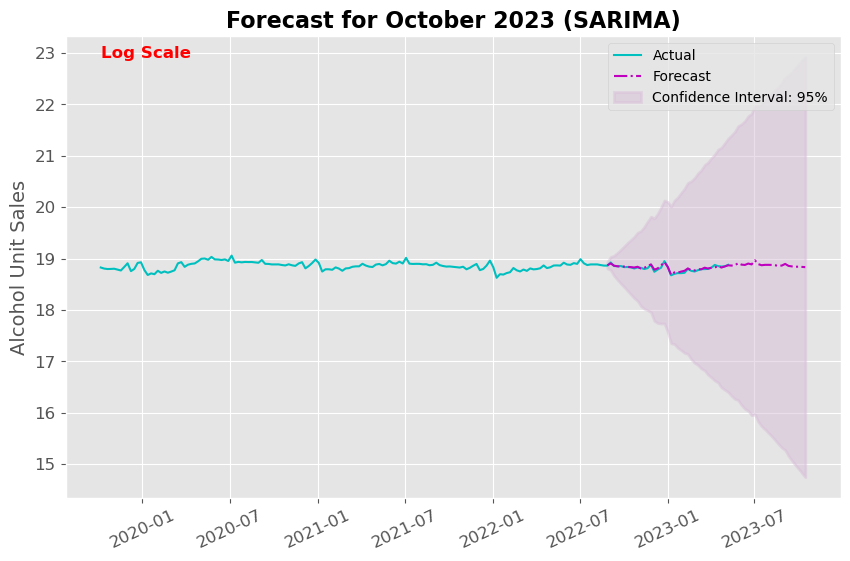

In [34]:
# Plot in Logarithmic Scale: SARIMA

plt.plot(df_alc_log, color = 'c', label = 'Actual')
plt.plot(sarima_forecast_log, color = 'm', label = 'Forecast', linestyle = '-.')
plt.fill_between(lower_bound_sarima_log.index, upper_bound_sarima_log, lower_bound_sarima_log,
                 alpha = 0.5, linewidth = 2, color = 'thistle', label = 'Confidence Interval: 95%')
plt.title(f"Forecast for {sarima_forecast_log.index.max().strftime('%B')} {sarima_forecast_log.index.max().year} (SARIMA)")
plt.text(df_alc_log.index[0], 22.9, 'Log Scale', fontsize = 12, color='red', fontweight = 'bold')
plt.ylabel('Alcohol Unit Sales')
plt.xticks(rotation = 25)
plt.legend()
plt.show()

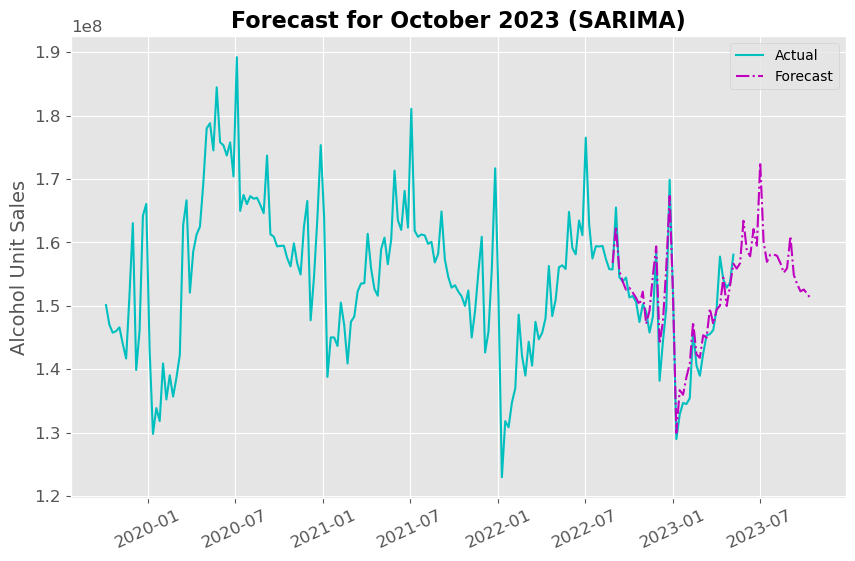

In [35]:
# Plot in original scale: SARIMA
    
plt.plot(df_alc, color = 'c', label = 'Actual')
plt.plot(sarima_forecast, color = 'm', label = 'Forecast', linestyle = '-.')
plt.title(f"Forecast for {sarima_forecast.index.max().strftime('%B')} {sarima_forecast.index.max().year} (SARIMA)")
plt.ylabel('Alcohol Unit Sales')
plt.xticks(rotation = 25)
plt.legend()
plt.show()

## SARIMAX

In [36]:
# Fitting the SARIMAX model

sarimax_model = SARIMAX(train_data_diff, order = auto_select.order, seasonal_order = auto_select.seasonal_order)
sarimax_model_fit = sarimax_model.fit()

In [37]:
# Forecasting the next 23 weeks

sarimax_results = sarimax_model_fit.get_forecast(steps = steps_diff)
sarimax_forecast_log_diff = sarimax_results.predicted_mean

In [38]:
# Reversing the forecasted data: cumulative sum

sarimax_forecast_cumsum = sarimax_forecast_log_diff.cumsum()


# Reversion for confidence intervals: cumulative sum

sarimax_conf_int_cumsum = sarimax_results.conf_int().cumsum()
lower_bound_sarimax_cumsum = sarimax_conf_int_cumsum.iloc[:,0]
upper_bound_sarimax_cumsum = sarimax_conf_int_cumsum.iloc[:,1]

In [39]:
# Reversing the forecast value: summing with the base value

sarimax_forecast_log = series_base_value.add(sarimax_forecast_cumsum, fill_value = 0)


# Reversing the forecast value in confidence intervals: summing with the base value

lower_bound_sarimax_log = series_base_value.add(lower_bound_sarimax_cumsum, fill_value = 0)
upper_bound_sarimax_log = series_base_value.add(upper_bound_sarimax_cumsum, fill_value = 0)

In [40]:
# Reversing the forecasted data to the original scale: exponentiation

sarimax_forecast = np.exp(sarimax_forecast_log)


# Reversing the forecasted data to the original scale for confidence intervals: exponentiation

lower_bound_sarimax = np.exp(lower_bound_sarimax_log)
upper_bound_sarimax = np.exp(upper_bound_sarimax_log)

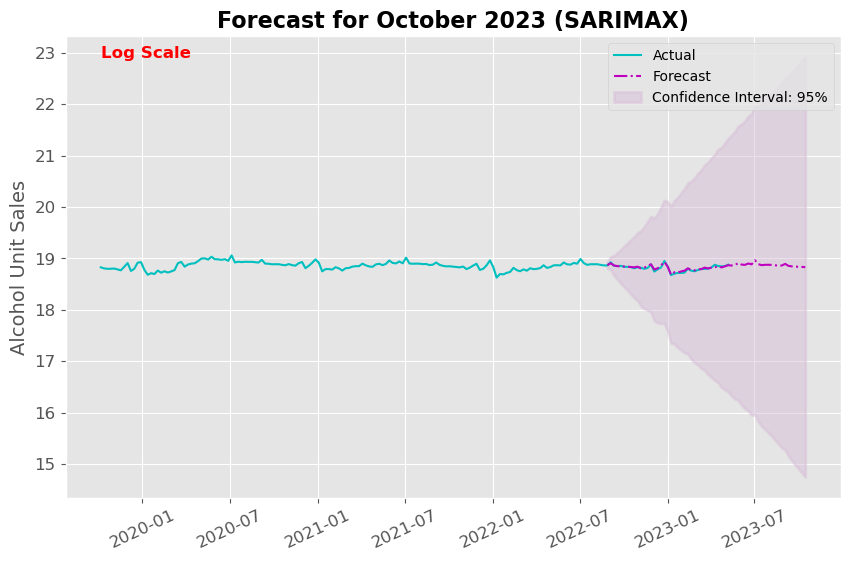

In [41]:
# Plot in logarithmic scale: SARIMAX
    
plt.plot(df_alc_log, color = 'c', label = 'Actual')
plt.plot(sarimax_forecast_log, color = 'm', label = 'Forecast', linestyle = '-.')
plt.fill_between(lower_bound_sarimax_log.index, upper_bound_sarimax_log, lower_bound_sarimax_log,
                 alpha = 0.5, linewidth = 2, color = 'thistle', label = 'Confidence Interval: 95%')
plt.title(f"Forecast for {sarimax_forecast_log.index.max().strftime('%B')} {sarimax_forecast_log.index.max().year} (SARIMAX)")
plt.text(df_alc_log.index[0], 22.9, 'Log Scale', fontsize = 12, color = 'r', fontweight = 'bold')
plt.ylabel('Alcohol Unit Sales')
plt.xticks(rotation = 25)
plt.legend()
plt.show()

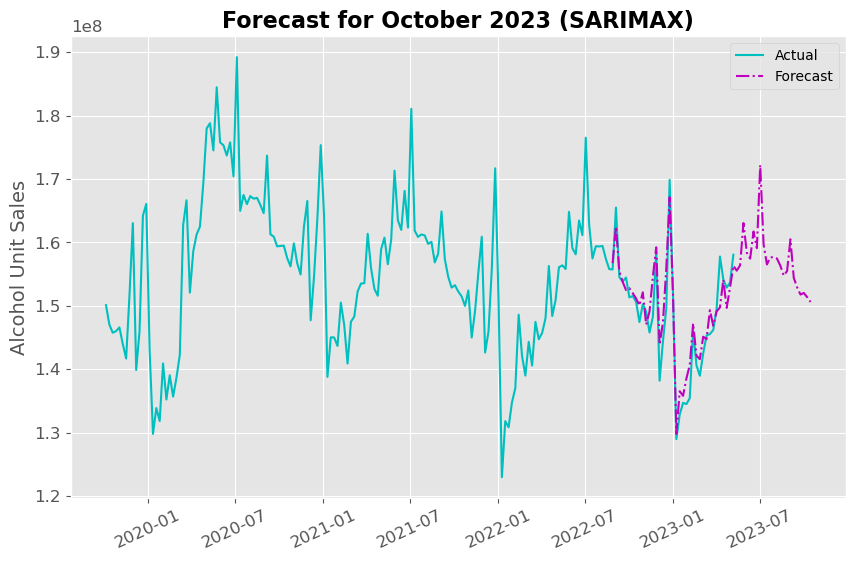

In [42]:
# Plot in original scale: SARIMAX
    
plt.plot(df_alc, color = 'c', label = 'Actual')
plt.plot(sarimax_forecast, color = 'm', label = 'Forecast', linestyle = '-.')
plt.title(f"Forecast for {sarimax_forecast.index.max().strftime('%B')} {sarimax_forecast.index.max().year} (SARIMAX)")
plt.ylabel('Alcohol Unit Sales')
plt.xticks(rotation = 25)
plt.legend()
plt.show()

## Exponential Smoothing

In [43]:
# Fitting the data with Exponential Smothing (TES) 

tes_model = ES(train_data, trend = 'add', damped_trend = True, seasonal = 'add', seasonal_periods = 52).fit()

In [44]:
# Optimal parameters

alpha = tes_model.model.params['smoothing_level']
beta = tes_model.model.params['smoothing_slope'] if 'smoothing_slope' in tes_model.model.params else None
gamma = tes_model.model.params['smoothing_seasonal'] if 'smoothing_seasonal' in tes_model.model.params else None
phi = tes_model.model.params['damping_slope'] if 'damping_slope' in tes_model.model.params else None


# Printing the optimal parameters scores

print(f"α (Smoothing Level): {alpha:.2f}")
print(f"β (Smoothing Slope): {beta:.2f}" if beta is not None else "β (Smoothing Slope): Not Applicable")
print(f"γ (Smoothing Seasonal): {gamma:.2f}" if gamma is not None else "γ (Smoothing Seasonal): Not Applicable")
print(f"ϕ (Damping Slope): {phi:.2f}" if phi is not None else "ϕ (Damping Slope): Not Applicable")

α (Smoothing Level): 0.54
β (Smoothing Slope): Not Applicable
γ (Smoothing Seasonal): 0.15
ϕ (Damping Slope): Not Applicable


In [45]:
# Forecasting with TES for the next 'steps_' weeks

steps_ = steps_diff + 1
tes_forecast = tes_model.forecast(steps_).iloc[1:]

In [46]:
# Computing confidence intervals

residuals = tes_model.resid
sigma = np.std(residuals)
z_score = 1.96  
lower_bound_tes = tes_forecast - (z_score * sigma)
upper_bound_tes = tes_forecast + (z_score * sigma)

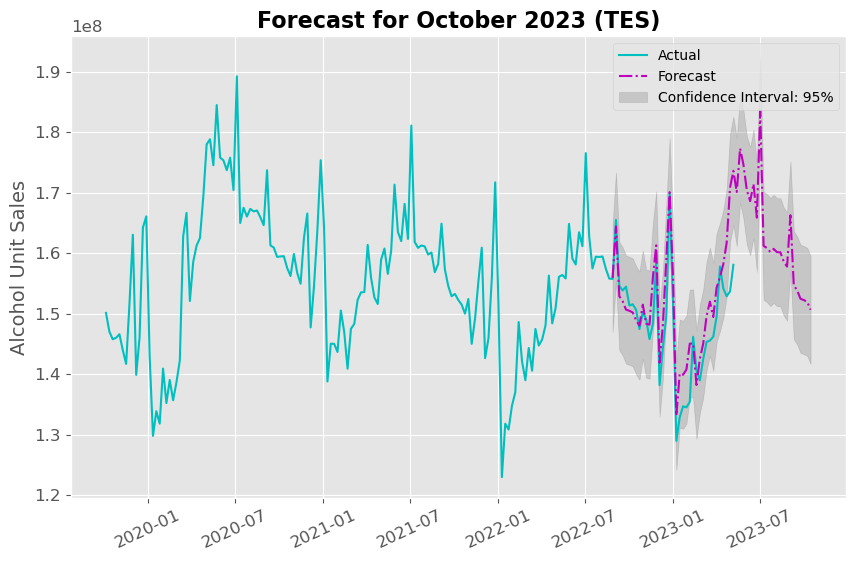

In [47]:
# Plot with TES forecast

plt.plot(df_alc, label = 'Actual', color = 'c')
plt.plot(tes_forecast, label = 'Forecast', color = 'm', linestyle = '-.')
plt.title(f"Forecast for {tes_forecast.index.max().strftime('%B')} {tes_forecast.index.max().year} (TES)")
plt.fill_between(tes_forecast.index, lower_bound_tes, upper_bound_tes, color = 'grey',
                 alpha = 0.3, label = 'Confidence Interval: 95%')
plt.ylabel('Alcohol Unit Sales')
plt.xticks(rotation = 25)
plt.legend()
plt.show()

## PROPHET

In [48]:
# Setting the dataframe to fit the model with Prophet

prophet_df = pd.DataFrame({'ds': train_data.index,
                           'y': train_data.squeeze()})

In [49]:
# Fitting the model

model_prophet = Prophet().fit(prophet_df)

11:08:33 - cmdstanpy - INFO - Chain [1] start processing
11:08:34 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
# Forecast for next 'steps_' weeks

model_prophet_steps_df = model_prophet.make_future_dataframe(periods = steps_, freq = 'W')

In [51]:
# Parameters from Prophet forecasts

forecasts = model_prophet.predict(model_prophet_steps_df)

In [52]:
# Taking the data forecasted for the 'steps' periods

prophet_forecast = forecasts.iloc[151:]

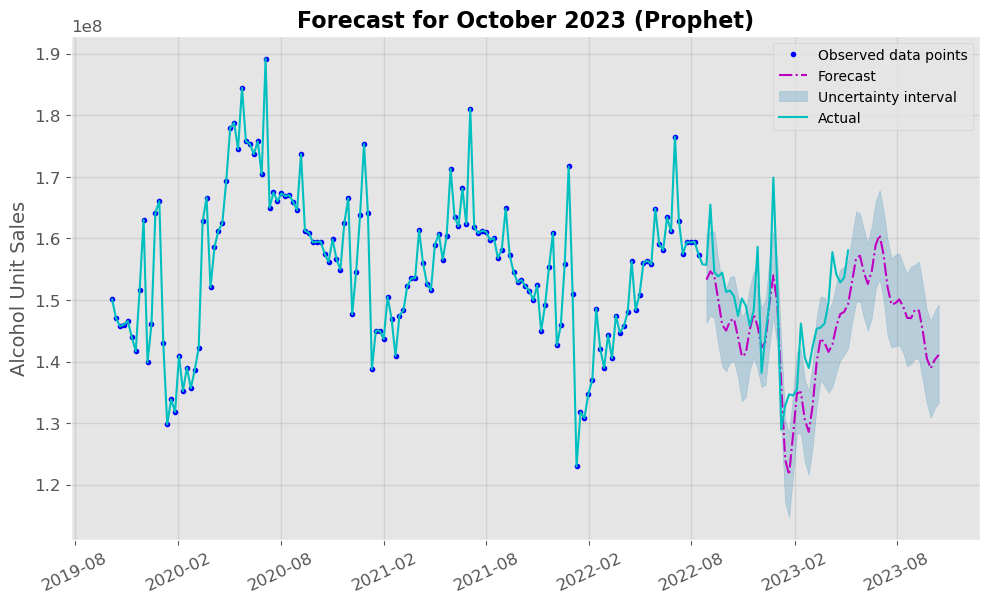

In [53]:
# plot

model_prophet.plot(prophet_forecast)
prophet_line_forecast = plt.gca().get_lines()[1]
prophet_line_forecast.set_color('m')
prophet_line_forecast.set_linestyle('-.')
prophet_datapoints = plt.gca().get_lines()[0]
prophet_datapoints.set_color('b')
plt.title(f"Forecast for {tes_forecast.index.max().strftime('%B')} {tes_forecast.index.max().year} (Prophet)")
plt.plot(df_alc, label = 'Actual', color = 'c')
plt.ylabel('Alcohol Unit Sales')
plt.xlabel('')
plt.xticks(rotation = 25)
plt.legend()
plt.show()

# Performance Assessment

In [54]:
# List of candidate models

sarima = sarima_forecast.iloc[:-23]
sarimax = sarimax_forecast.iloc[:-23]
tes = tes_forecast.iloc[:-23]
prophet = prophet_forecast.iloc[:-23, -1:]
forecast_models_list = [('SARIMA', sarima), ('SARIMAX', sarimax), ('TES', tes), ('Prophet', prophet)]

In [55]:
# Setting the initial data point of the test set to be equal to the forecasted  

if test_data.index[0] == test_data_diff.index[0]:
    eval_data = test_data   
else:
    eval_data = test_data.iloc[1:]  

In [56]:
# Re-setting the data in prophet forecast dataframe 

prophet.index = eval_data.index

- Comparing the forecast results with the actual values

In [57]:
evaluate(forecast_models_list, eval_data, 'results')

,2022-08-28,2022-09-04,2022-09-11,2022-09-18,2022-09-25,2022-10-02,2022-10-09,2022-10-16,2022-10-23,2022-10-30
Actual,1.557263e+08,1.654902e+08,1.545241e+08,1.538235e+08,1.544509e+08,1.513215e+08,1.515360e+08,1.506181e+08,1.474300e+08,1.502449e+08
SARIMA,1.567514e+08,1.625122e+08,1.555352e+08,1.538304e+08,1.525355e+08,1.528414e+08,1.520752e+08,1.512283e+08,1.501415e+08,1.522286e+08
SARIMAX,1.567287e+08,1.624775e+08,1.554887e+08,1.537772e+08,1.524739e+08,1.527706e+08,1.519959e+08,1.511404e+08,1.500468e+08,1.521248e+08
TES,1.558970e+08,1.644032e+08,1.528659e+08,1.520253e+08,1.506519e+08,1.504586e+08,1.501845e+08,1.488980e+08,1.480109e+08,1.514673e+08
Prophet,1.533048e+08,1.546635e+08,1.538969e+08,1.500285e+08,1.459709e+08,1.450352e+08,1.466208e+08,1.469299e+08,1.440672e+08,1.408522e+08


- Comparing the performance metrics across the candidate models

In [58]:
evaluate(forecast_models_list, eval_data, 'metrics')

,MSE,RMSE,MAE,MAPE
SARIMA,9.526976e+12,3.086580e+06,2.374340e+06,0.016215
SARIMAX,9.240337e+12,3.039792e+06,2.330547e+06,0.015878
TES,3.281246e+13,5.728217e+06,4.242597e+06,0.028922
Prophet,5.925240e+13,7.697558e+06,6.431030e+06,0.043222


# END